This Jupyter Notebook has been modified from code originally developed by [Angel Paredes](https://scholar.google.com/citations?hl=en&user=bAMNXzYAAAAJ) and [Pietro Favaro](https://scholar.google.com/citations?hl=en&user=p-zTDnMAAAAJ). Thanks for their contributions.

# Install (Colab Only)

In [ ]:
# download simbench
!git clone https://github.com/e2nIEE/simbench.git
# install aiopvpc
!pip install aiopvpc
# install meteostat
!pip install meteostat
# install pyepo
!pip install pyepo

Cloning into 'simbench'...
remote: Enumerating objects: 1085, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 1085 (delta 114), reused 176 (delta 109), pack-reused 894
Receiving objects: 100% (1085/1085), 67.24 MiB | 6.43 MiB/s, done.
Resolving deltas: 100% (679/679), done.
Updating files: 100% (164/164), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-1

Remove the problematic hook from Google Colab.

In [ ]:
import sys
sys.meta_path = [hook for hook in sys.meta_path if not any(keyword in str(hook) for keyword in ["google.colab"])]

# Energy Scheduling

In this tutorial, we will explore a real-world energy scheduling problem. T

In [ ]:
# set random seed
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 1 Data

### 1.1 Energy Load Data

SimBench (www.simbench.net) is a research project to create a "simulation database for uniform comparison of innovative solutions in the field of network analysis, network planning and operation", which was conducted for three and a half years from 1.11.2015 to 30.04.2019.

In [ ]:
import pandas as pd

# load the dataset from a CSV file
df = pd.read_csv('./simbench/simbench/networks/1-complete_data-mixed-all-0-sw/LoadProfile.csv',sep=';')
print('The size of the dataset is ({:},{:})'.format(len(df.index),len(df.columns)))
display(df.head())

The size of the dataset is (35136,193)


,time,BL-H_qload,BL-H_pload,G0-A_qload,G0-A_pload,G0-M_qload,G0-M_pload,G1-A_qload,G1-A_pload,G1-B_qload,...,HS25_pload,HS25_qload,HS26_pload,HS26_qload,HS27_pload,HS27_qload,HSexp0_pload,HSexp0_qload,HSexp1_pload,HSexp1_qload
0,01.01.2016 00:00,0.143050,0.088339,0.282542,0.143882,0.256264,0.275641,0.056108,0.039528,0.000000,...,0.652520,0.214473,0.653424,0.214770,0.446373,0.146716,0.806813,0.265187,0.966765,0.317760
1,01.01.2016 00:15,0.169872,0.084806,0.389736,0.203032,0.473602,0.283333,0.007014,0.026333,0.021812,...,0.653845,0.214909,0.651595,0.214169,0.441562,0.145134,0.806813,0.265187,0.962273,0.316284
2,01.01.2016 00:30,0.169872,0.077739,0.402408,0.213184,0.376287,0.248718,0.008837,0.027719,0.021812,...,0.655171,0.215344,0.649767,0.213568,0.436751,0.143553,0.806813,0.265187,0.957781,0.314807
3,01.01.2016 00:45,0.151991,0.081272,0.329803,0.170953,0.434676,0.269231,0.012344,0.029826,0.010906,...,0.656496,0.215780,0.647938,0.212967,0.431940,0.141972,0.806813,0.265187,0.953289,0.313331
4,01.01.2016 01:00,0.151991,0.081272,0.385284,0.191256,0.437920,0.271795,0.007014,0.027054,0.000000,...,0.657822,0.216216,0.646110,0.212366,0.427129,0.140390,0.806813,0.265187,0.948797,0.311855


In [ ]:
# set 'time' as the index and select the 'mv_comm_pload' column
df_load = df.set_index("time").loc[:,"mv_comm_pload"]
# convert the datetime format
df_load.index = pd.to_datetime(df_load.index, format="%d.%m.%Y %H:%M")
# remove the index name
df_load.index.name = None
# resample to 1h resolution
df_load = df_load.resample("1H").mean()
# rename the column
df_load = df_load.rename('load')
# to dataframe
df_load = pd.DataFrame(df_load)
# display
print()
display(df_load.head())

,load
2016-01-01 00:00:00,0.160756
2016-01-01 01:00:00,0.166248
2016-01-01 02:00:00,0.149171
2016-01-01 03:00:00,0.140763
2016-01-01 04:00:00,0.132669


### 1.2 Price Data

Simple aio library (https://github.com/azogue/aiopvpc) to download Spanish electricity hourly prices.

In [ ]:
from datetime import datetime, timedelta
# base date to start data
base = datetime(2022, 1, 1)
# number of days to import starting from base
date_list = [base + timedelta(days=x) for x in range(366)]

In [ ]:
import aiohttp
from aiopvpc import PVPCData

# empty DataFrame
df_price = pd.DataFrame(columns=["time", "price"])

# retrieve the price data
async with aiohttp.ClientSession() as session:
    for h in date_list:
        # init the PVPCData handle
        pvpc_handler = PVPCData(session=session, tariff="2.0TD")
        # retrieve the data for the current date
        esios_data = await pvpc_handler.async_update_all(
             current_data=None, now=h
        )
        # extract time and price
        k = [str(k) for k in esios_data.sensors["PVPC"].keys()]
        p = [v for v in esios_data.sensors["PVPC"].values()]
        p_i = pd.DataFrame({"time": k, "price": p})
        # add to df
        df_price = pd.concat([df_price, p_i])

# display
display(df_load.head())

,load
2016-01-01 00:00:00,0.160756
2016-01-01 01:00:00,0.166248
2016-01-01 02:00:00,0.149171
2016-01-01 03:00:00,0.140763
2016-01-01 04:00:00,0.132669


### 1.3 Climate Data

The Meteostat Python library (https://dev.meteostat.net/python) provides simple access to open weather and climate data using Pandas.

In [ ]:
from meteostat import Stations, Hourly
# time period
start = datetime(2022, 1, 1)
end = datetime(2023, 1, 3)
# station object for Spain
stations = Stations().region("ES")
# get hourly data for 2022
data = Hourly(stations.fetch(), start, end)
# normalize data
data = data.normalize()
# aggregate data spatially
data = data.aggregate(freq="1H", spatial=True)
# fetch data
df_climate = data.fetch()
# display
display(df_climate.head())

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2022-01-01 00:00:00,10.1,5.0,75.2,0.0,NaN,160.3,7.9,20.9,1026.9,0.0,2.2
2022-01-01 01:00:00,9.9,4.6,74.7,0.0,NaN,158.1,8.0,22.0,1026.7,0.0,2.2
2022-01-01 02:00:00,9.6,4.5,75.2,0.0,NaN,168.2,7.9,21.6,1026.7,0.0,2.1
2022-01-01 03:00:00,9.4,4.0,74.0,0.0,NaN,156.0,7.9,21.8,1026.7,0.0,2.4
2022-01-01 04:00:00,9.1,3.7,73.8,0.0,NaN,154.6,7.7,20.9,1026.6,0.0,2.4


### 1.4 Joint Dataset for Training

In [ ]:
# random flexibility bound of demand
plo_t = df_load.load.values * (0.7 + 0.1 * np.random.rand(df_load.values.size)) # lower bound
pup_t = df_load.load.values * (1.2 + 0.1 * np.random.rand(df_load.values.size)) # upper bound
# joint dataset
df = pd.DataFrame({"pi_t": df_price.price.values,                               # price
                   "temp": df_climate.temp.values[:df_price.shape[0]],          # temperature
                   "rhum": df_climate.rhum.values[:df_price.shape[0]],          # relative humidity
                   "wdir": df_climate.wdir.values[:df_price.shape[0]],          # wind direction
                   "wspd": df_climate.wspd.values[:df_price.shape[0]],          # wind speed
                   "pres": df_climate.pres.values[:df_price.shape[0]],          # pressure
                   "tsun": df_climate.tsun.values[:df_price.shape[0]],          # number of minutes of sunshine in the hour
                   "Psch_t": df_load.load.values,                               # scheduled load
                   "Plo_t": plo_t,                                              # flexibility lower bound of load
                   "Pup_t": pup_t                                               # flexibility upper bound of load
    })
display(df.head())

,pi_t,temp,rhum,wdir,wspd,pres,tsun,Psch_t,Plo_t,Pup_t
0,0.20451,10.1,75.2,160.3,7.9,1026.9,0.0,0.160756,0.118550,0.202013
1,0.17135,9.9,74.7,158.1,8.0,1026.7,0.0,0.166248,0.132179,0.207341
2,0.17270,9.6,75.2,168.2,7.9,1026.7,0.0,0.149171,0.115339,0.186401
3,0.15607,9.4,74.0,156.0,7.9,1026.7,0.0,0.140763,0.106961,0.179223
4,0.15908,9.1,73.8,154.6,7.7,1026.6,0.0,0.132669,0.094938,0.160367


In [ ]:
def nanFill(x):
    """
    A function to replaces NaN values with the mean of the previous and next values.
    """
    if x.ndim == 2:
        # iterate over columns in a 2D array
        for j in range(x.shape[1]):
            # get index of nan
            nan_indices = np.where(np.isnan(x[:, j]))[0]
            for i in nan_indices:
                # fill nan by mean
                if 0 < i < len(x) - 1:
                    x[i, j] = np.nanmean([x[i - 1, j], x[i + 1, j]])
                # boundary cases
                elif i == 0:
                    x[i, j] = x[i + 1, j]
                elif i == len(x) - 1:
                    x[i, j] = x[i - 1, j]
    elif x.ndim == 3:
        # iterate over 3rd dimension in a 3D array
        for k in range(x.shape[2]):
            for j in range(x.shape[1]):
                # get index of nan
                nan_indices = np.where(np.isnan(x[:, j, k]))[0]
                for i in nan_indices:
                    # fill nan by mean
                    if 0 < i < len(x) - 1:
                        x[i, j, k] = np.nanmean([x[i - 1, j, k], x[i + 1, j, k]])
                    # boundary cases
                    elif i == 0:
                        x[i, j, k] = x[i + 1, j, k]
                    elif i == len(x) - 1:
                        x[i, j, k] = x[i - 1, j, k]
    return x

In [ ]:
# get features
df_feat = df[["pi_t", "temp", "wdir"]].reset_index(drop=True)
# features and costs
lookback_window = 3
# observable features (price, temperature, and wind direction for previous day)
x = np.array([df_feat.iloc[d * 24:(d + lookback_window) * 24, :].values for d in range(0, 365 - lookback_window)])
x = nanFill(x)
# reshape the 3D arrays to 2D arrays
x = x.reshape(x.shape[0], -1)
# labeled costs (true electricity price vector for tomorrow)
c = np.array([df.iloc[d * 24:(d + 1) * 24, 1].values for d in range(lookback_window, 365)])
c = nanFill(c)
# get the flexibility bounds and scheduled load
plo_t = df.loc[:23, 'Plo_t'].values
psch_t = df.loc[:23, 'Psch_t'].values
pup_t = df.loc[:23, 'Pup_t'].values

In [ ]:
# data split
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=30, random_state=246)
print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)
print("c_train.shape:", c_train.shape)
print("c_test.shape:", c_test.shape)

x_train.shape: (332, 216)
x_test.shape: (30, 216)
c_train.shape: (332, 24)
c_test.shape: (30, 24)


## 2 Optimization Model

Let $\pi_t$ be the price of the next day electricity market for all time steps $t\in\Omega_t$. A demand response program want to schedule their consumption $p_t$ between a lower $\underline{P}_t$ and upper $\overline{P}_t$ bounds for the next day without knowing the actual price. Nevertheless, the overall consumption of the day $P_t^{sch}$ must remain constant. We are asumming there is flexibility moving the demand fro one time step to another, but the overall demand must be computed.

The optimization problem with perfect information is:

$$\min_{p_t} \sum_t \pi_t p_t$$
$$s.t. \quad \underline{P}_t \leq p_t \leq \overline{P}_t, \hspace{10pt} \forall t \\
\sum_t p_t = \sum_t P_t^{sch}
$$


In [ ]:
import gurobipy as gp
from pyepo.model.grb import optGrbModel

class DemandResponse(optGrbModel):
    """
    This class is an optimization model for energy scheduling.

    Attributes:
        _model (model): a Pyomo model
        plo_t (np.ndarray / list): lower bound of the demand
        psch_t (np.ndarray / list): scheduled  demand
        pup_t (np.ndarray / list): upper bound of the demand
    """

    def __init__(self, plo_t, psch_t, pup_t):
        """
        Args:
            plo_t (np.ndarray / list): lower bound of the demand
            psch_t (np.ndarray / list): scheduled  demand
            pup_t (np.ndarray / list): upper bound of the demand
        """
        self.plo_t = np.array(plo_t)
        self.psch_t = np.array(psch_t)
        self.pup_t = np.array(pup_t)
        super().__init__()

    def _getModel(self):
        # create a model
        m = gp.Model("Energy")
        # variables
        x = m.addMVar(24, lb=self.plo_t, ub=self.pup_t, name="x")
        # constr
        m.addConstr(gp.quicksum(x) == gp.quicksum(self.psch_t))
        return m, x

Auto-Sklearn cannot be imported.


In [ ]:
# init model
optmodel = DemandResponse(plo_t, psch_t, pup_t)
# solve model (just test)
optmodel.setObj(c_test[0]) # set objective function
sol, obj = optmodel.solve() # solve
# print res
print('Obj: {}'.format(obj))
print('Sol: {}'.format(sol))

Restricted license - for non-production use only - expires 2025-11-24
Obj: 126.18739165466128
Sol: [0.20201344 0.20734108 0.18640139 0.17922344 0.16036727 0.14570371
 0.16781868 0.16711281 0.17530921 0.17114743 0.10355415 0.14040012
 0.16840809 0.17103557 0.18135329 0.18394221 0.17464827 0.22911266
 0.19452466 0.20723267 0.27147243 0.26636024 0.23349256 0.19769213]


## 3 Dataset and Data Loader

> "PyTorch provides two data primitives: ``Dataset`` and ``DataLoader`` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples. "  -- PyTorch Documentation

``optDataset`` is extended from PyTorch ``Dataset``. In order to obtain optimal solutions, ``optDataset`` requires the corresponding ``optModel`` is a module of PyEPO library, which is designed as a container for any "black box" solver. The tutorial on ``optModel`` is [here](https://github.com/khalil-research/PyEPO/blob/main/notebooks/01%20Optimization%20Model.ipynb).

In [ ]:
import pyepo
# get training data set
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
# get test data set
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 332/332 [00:00<00:00, 1473.79it/s]


Optimizing for optDataset...


100%|██████████| 30/30 [00:00<00:00, 1289.85it/s]


In [ ]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 4
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

## 4 PyTorch Linear Regression

PyTorch is an open-source machine learning library primarily used for developing and training deep learning models such as neural networks. It is developed by Facebook's AI Research lab and is based on the Torch library. PyTorch provides a flexible and intuitive interface for creating and training models.

In PyTorch, the ``nn.Module`` is a base class for all neural network modules in the library. It provides a convenient way to organize the layers of a model, and to define the forward pass of the model.

Here, we build a MLP with a hidden layer.

In [ ]:
import torch
from torch import nn

class multiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(multiLayerPerceptron, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [ ]:
# model size
input_dim = x.shape[-1]
output_dim = c.shape[-1]
hidden_dim = 48
# init for test
reg = multiLayerPerceptron(input_dim, hidden_dim, output_dim)

## 5 Training and Testing

The core capability of PyEPO is to embed the optimization model into an artificial neural network for the end-to-end training. For this purpose, PyEPO includes several different methods.

### 5.1 Visualization Functions

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
def visSol(plo_t, pup_t, data_loader, optmodel, ind=0,
           pytorch_model=None, sklearn_model=None, method_name=None):
    # iterating over data loader
    for i, data in enumerate(data_loader):
        if i == ind:
            # load data
            x, c, w, z = data
            # move to GPU if available
            if torch.cuda.is_available():
                x = x.cuda()
            # convert to numpy
            c = c.cpu().detach().numpy()[0]
            w = w.cpu().detach().numpy()[0]
            z = z.cpu().detach().numpy()[0]
            # predict with pytorch
            if pytorch_model is not None:
                cp = pytorch_model(x)
                cp = cp.cpu().detach().numpy()[0]
            # predict with sklearn
            elif sklearn_model is not None:
                x = x.cpu().detach().numpy()
                cp = sklearn_model.predict(x)[0]
            # ground truth
            else:
                cp = c
            # plot
            fig = plotSol(c, cp, plo_t, pup_t, ind, method_name)
            break

In [ ]:
# plot function
def plotSol(c, cp, plo_t, pup_t, ind, method):
    # solve get optimal solution
    optmodel.setObj(c)
    w, _ = optmodel.solve()
    optmodel.setObj(cp)
    wp, _ = optmodel.solve()
    # calculate total cost
    total_cost = np.sum(c * wp)
    # hours
    t = range(24)
    # plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    # figure 1: price
    axs[0].plot(t, cp, color="b", linewidth=2, linestyle="--", label="Predicted Price")
    axs[0].plot(t, c, color="orange", linewidth=2, label="True Price")
    axs[0].legend(loc="upper left", shadow=False)
    axs[0].set_xlabel("Time (Hour)", fontsize=12)
    axs[0].set_ylabel("Price (€/kWh)", fontsize=12)
    axs[0].set_title("Price Prediction")
    # figure 2: load
    axs[1].plot(t, plo_t, color="r", linewidth=1, alpha=0.8, label="Bounds")
    axs[1].plot(t, pup_t, color="r", alpha=0.8, linewidth=1)
    axs[1].plot(t, wp, color="b", linewidth=2, linestyle="--", marker=".", label="Predicted Load", zorder=4)
    axs[1].plot(t, w, color="orange", linewidth=2, marker=".", label="True Load")
    axs[1].legend(loc="upper left", shadow=False)
    axs[1].set_xlabel("Time (Hour)", fontsize=12)
    axs[1].set_ylabel("Demand (p.u.)", fontsize=12)
    axs[1].set_title("Load Decision")
    # add title
    fig.suptitle("Instance {}, Total Cost for {}: {:.2f}".format(ind, method, total_cost))
    plt.show()

In [ ]:
def plotLearningCurve(logs, method):
    # plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=False)
    # figure 1: loss
    axs[0].plot(logs["loss"], color="c", linewidth=1)
    # set the x and y axis tick parameters
    axs[0].tick_params(axis="x", labelsize=10)
    axs[0].tick_params(axis="y", labelsize=10)
    # set the x axis limits
    axs[0].set_xlim(-1, len(logs["loss"])+1)
    # set the labels and title
    axs[0].set_xlabel("Iters", fontsize=12)
    axs[0].set_ylabel("Loss", fontsize=12)
    axs[0].set_title("Loss Curve on Training Set")
    # figure 2: regret
    axs[1].plot(100*logs["regret_train"], color="c", linewidth=2, label="Training")
    axs[1].plot(100*logs["regret_test"], color="g", linewidth=2, label="Test")
    # set the x and y axis tick parameters
    axs[1].tick_params(axis="x", labelsize=10)
    axs[1].tick_params(axis="y", labelsize=10)
    # set the x axis limits
    axs[1].set_xlim(-0.2, len(logs["regret_train"])-1+0.2)
    axs[1].set_ylim(0, 5)
    # set the labels and title
    axs[1].set_xlabel("Epochs", fontsize=12)
    axs[1].set_ylabel("Regret (%)", fontsize=12)
    axs[1].legend(loc="upper right", shadow=False)
    axs[1].set_title("Regret Curve on Training and Test Set")
    # add title
    fig.suptitle("Learning Curve for {}, Training Time: {:.2f} sec".format(method, logs["elapsed"]))
    plt.show()

### 5.2 Training

In [ ]:
import time
from tqdm import tqdm

def trainModel(reg, func, method_name, loader_train, loader_test, optmodel,
                device="cpu", lr=1e-1, num_epochs=1):
    """
    Train a model using PyEPO.
    """
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init loss functions
    l1 = nn.L1Loss()
    l2 = nn.MSELoss()
    # set model to training mode
    reg.train()
    # init log
    loss_log, regret_log_train, regret_log_test = [], [], []
    tbar = tqdm(range(num_epochs))
    elapsed = 0
    for epoch in tbar:
        # eval
        regret_train = pyepo.metric.regret(reg, optmodel, loader_train)
        regret_log_train.append(regret_train)
        regret_test = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_test.append(regret_test)
        # record time elapsed for training
        tick = time.time()
        # iterate over data mini-batches
        for i, data in enumerate(loader_train):
            # load data
            x, c, w, z = data
            # send to device
            x, c, w, z = x.to(device), c.to(device), w.to(device), z.to(device)
            # forward pass
            cp = reg(x) # prediction
            if method_name == "SPO+":
                # spo+ loss
                loss = func(cp, c, w, z)
            elif method_name == "PFYL"  or method_name == "NCE":
                # pfyl/nce loss
                loss = func(cp, w)
            elif method_name == "DBB" or method_name == "NID":
                # black-box optimizer
                wp = func(cp)
                # objective value
                zp = (wp * c).sum(1).view(-1, 1)
                # regret loss
                loss = l1(zp, z)
            elif method_name == "DPO":
                # perturbed optimizer
                we = func(cp)
                # l2 loss
                loss = l2(we, w)
            elif  method_name == "I-MLE" or  method_name == "AI-MLE":
                # implicit MLE
                we = func(cp)
                # l1 loss
                loss = l1(we, w)
            elif "LTR" in method_name or method_name == "2-Stage":
                # ranking/prediction loss
                loss = func(cp, c)
            else:
                raise ValueError("Unknown method_name: {}".format(method_name))
            # regularization term
            #loss += 10 * l2(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record loss
            loss_log.append(loss.item())
            # update progress bar
            tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
            # elapsed time
            tock = time.time()
            elapsed += tock - tick
    # eval
    regret_train = pyepo.metric.regret(reg, optmodel, loader_train)
    regret_log_train.append(regret_train)
    regret_test = pyepo.metric.regret(reg, optmodel, loader_test)
    regret_log_test.append(regret_test)
    # save logs
    logs = {}
    logs["loss"] = np.array(loss_log)
    logs["regret_train"] = np.array(regret_log_train)
    logs["regret_test"] = np.array(regret_log_test)
    logs["elapsed"] = elapsed
    # final result
    print("{}: Regret on test set: {:.2f}% after {:.2f} sec of training".format(method, regret_test*100, elapsed))
    return logs

Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Method: 2-Stage


Epoch:  4, Loss: 4.1760: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


2-Stage: Regret on test set: 0.14% after 106.59 sec of training


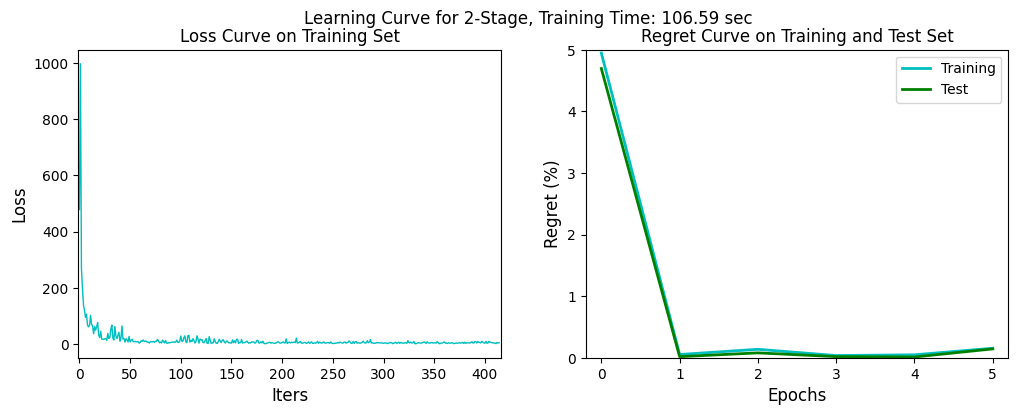

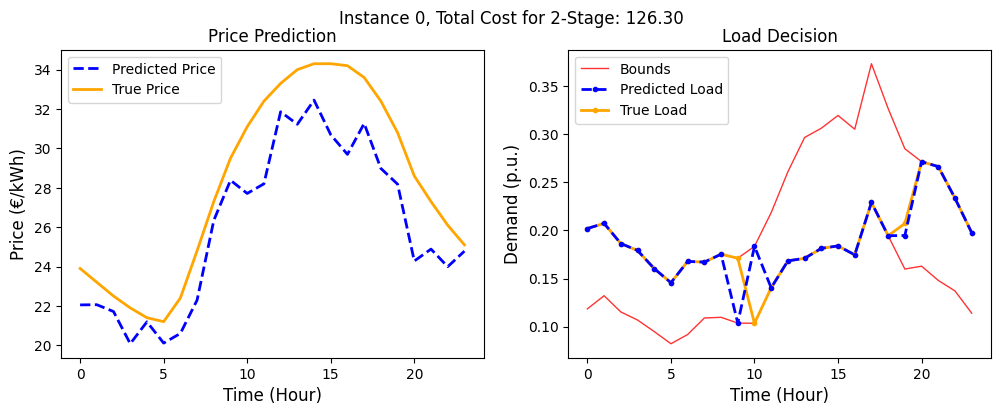





Method: SPO+


Epoch:  4, Loss: 0.1028: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


SPO+: Regret on test set: 0.00% after 569.04 sec of training


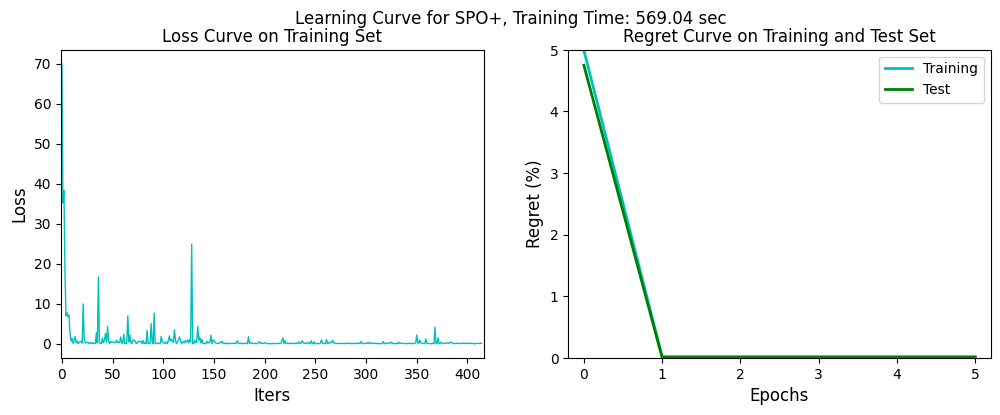

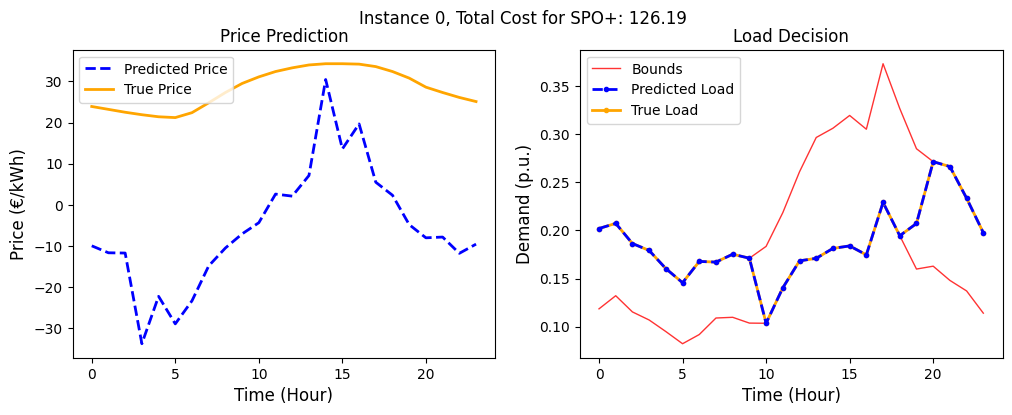





Method: DBB


Epoch:  4, Loss: 0.6234: 100%|██████████| 5/5 [00:25<00:00,  5.17s/it]


DBB: Regret on test set: 0.79% after 953.01 sec of training


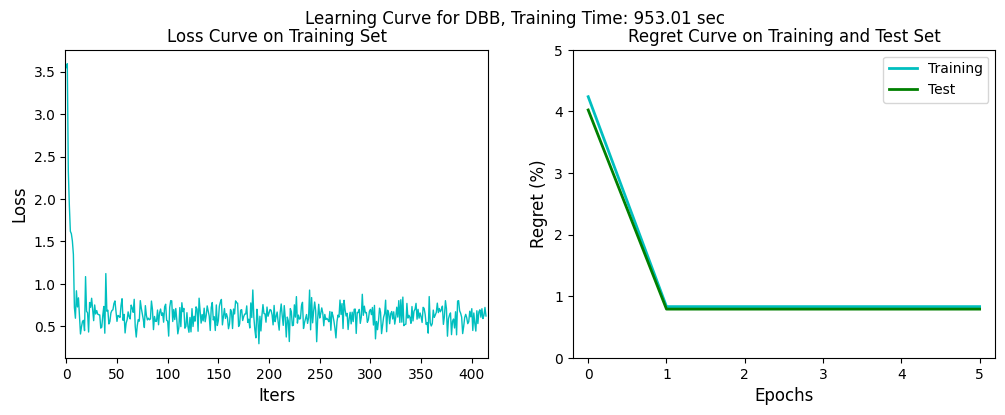

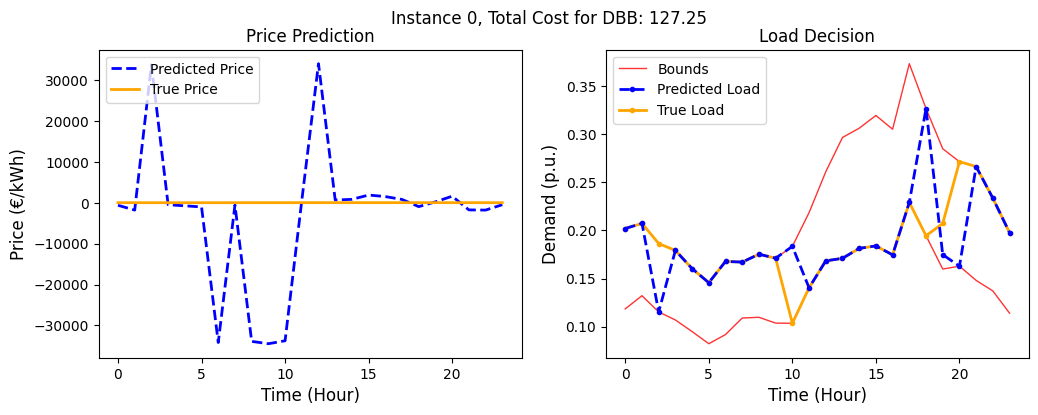





Method: NID


Epoch:  4, Loss: 0.8989: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


NID: Regret on test set: 0.88% after 591.23 sec of training


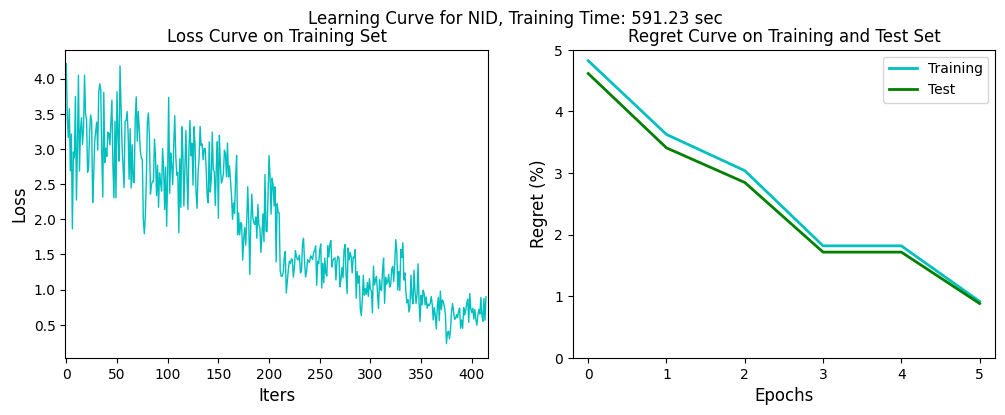

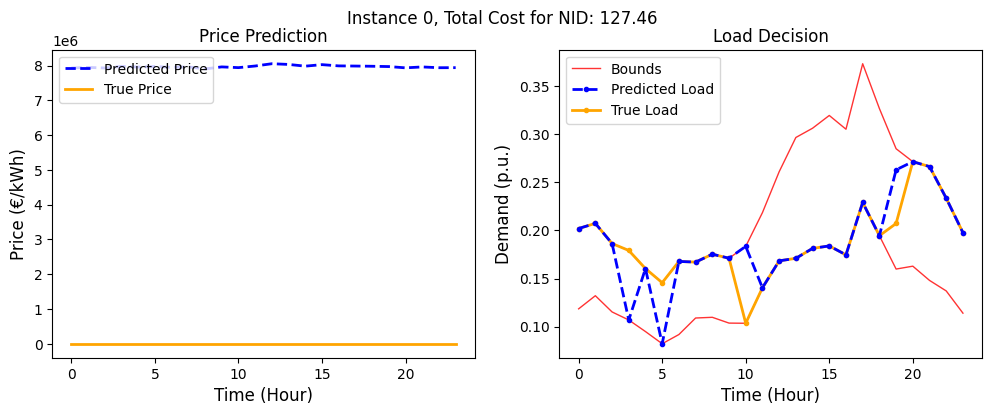





Method: DPO


Epoch:  4, Loss: 0.0022: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


DPO: Regret on test set: 0.80% after 607.83 sec of training


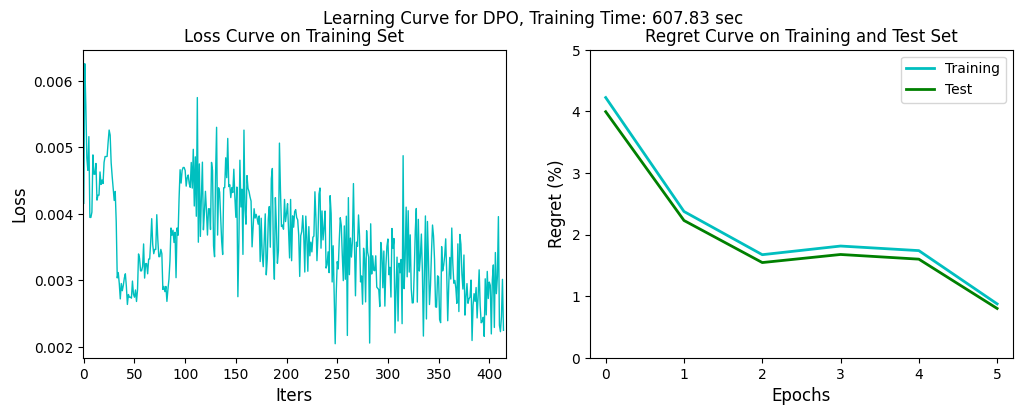

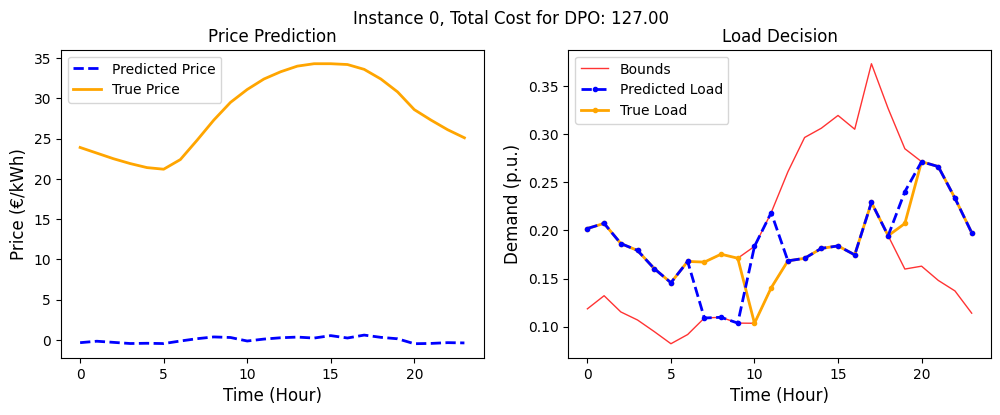





Method: PFYL


Epoch:  4, Loss: 0.0167: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


PFYL: Regret on test set: 0.00% after 663.09 sec of training


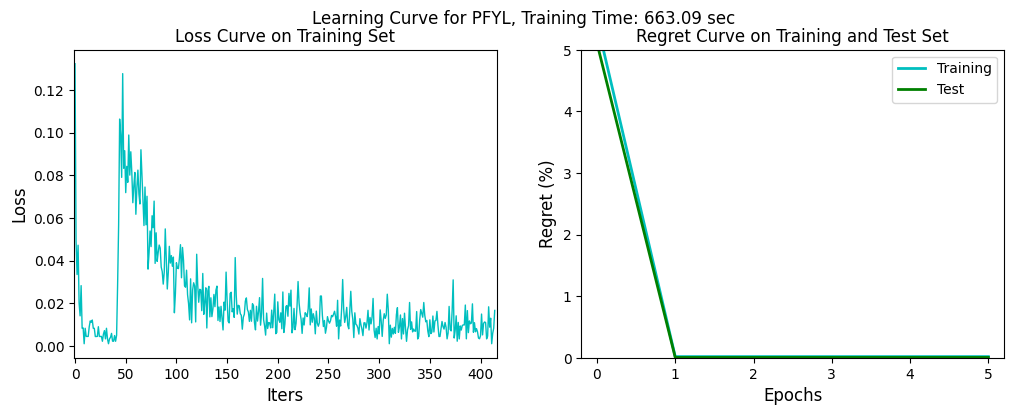

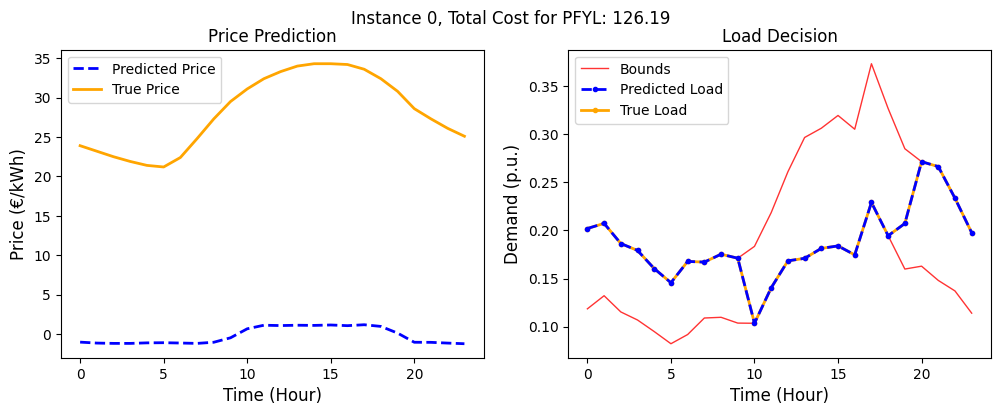





Method: I-MLE


Epoch:  4, Loss: 0.0337: 100%|██████████| 5/5 [00:25<00:00,  5.20s/it]


I-MLE: Regret on test set: 2.95% after 1000.34 sec of training


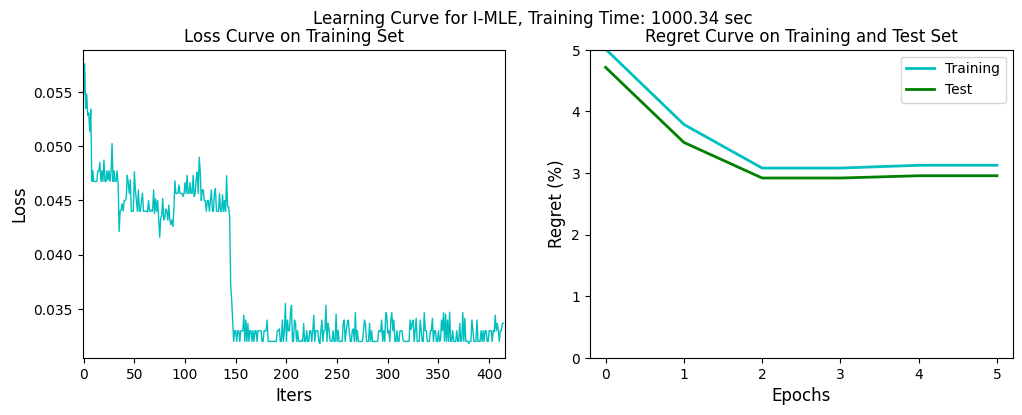

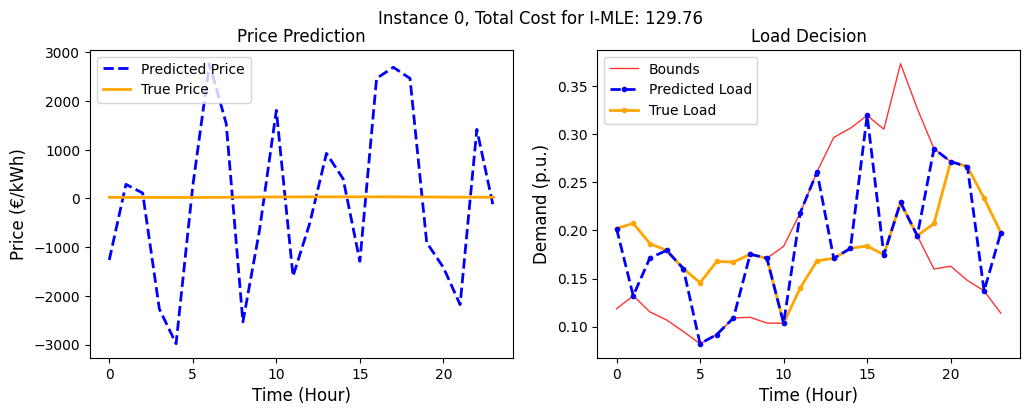





Method: AI-MLE


Epoch:  4, Loss: 0.0059: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]


AI-MLE: Regret on test set: 0.06% after 1095.97 sec of training


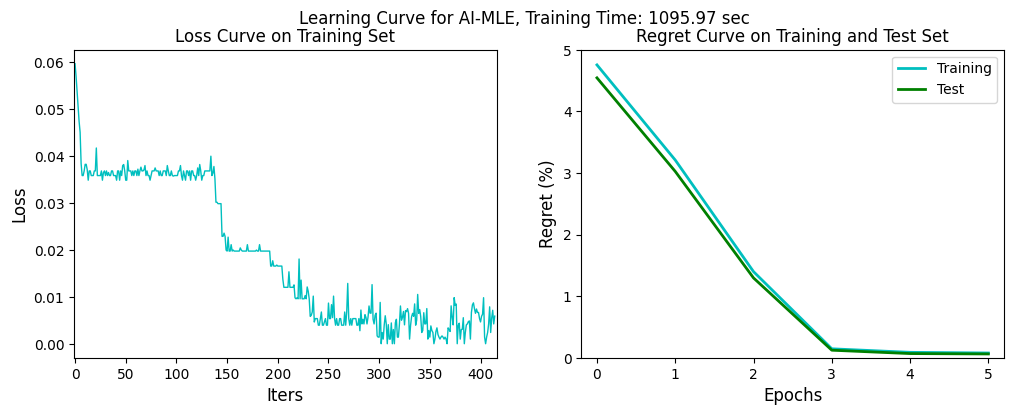

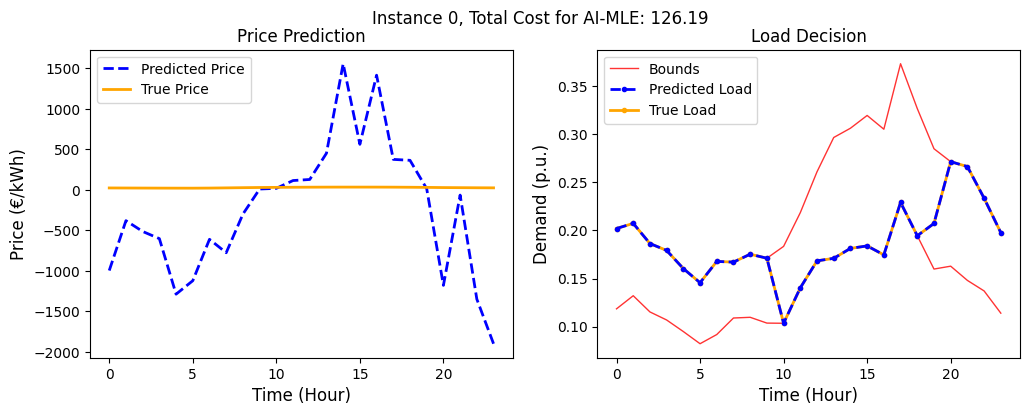





Method: NCE


Epoch:  4, Loss: -1062589.7500: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


NCE: Regret on test set: 0.00% after 170.27 sec of training


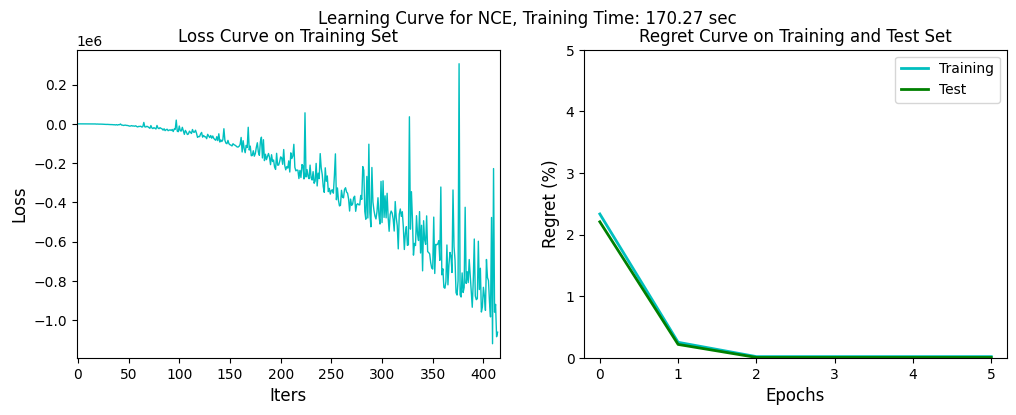

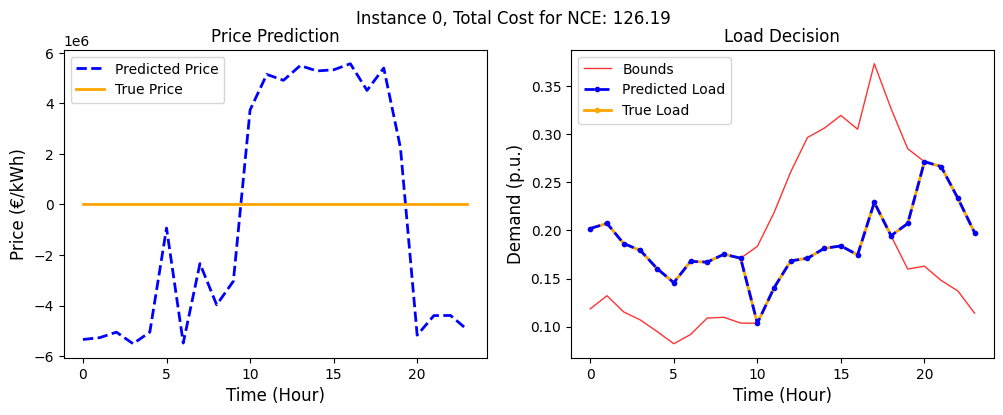





Method: Listwise LTR


Epoch:  4, Loss: 0.1280: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Listwise LTR: Regret on test set: 0.52% after 151.90 sec of training


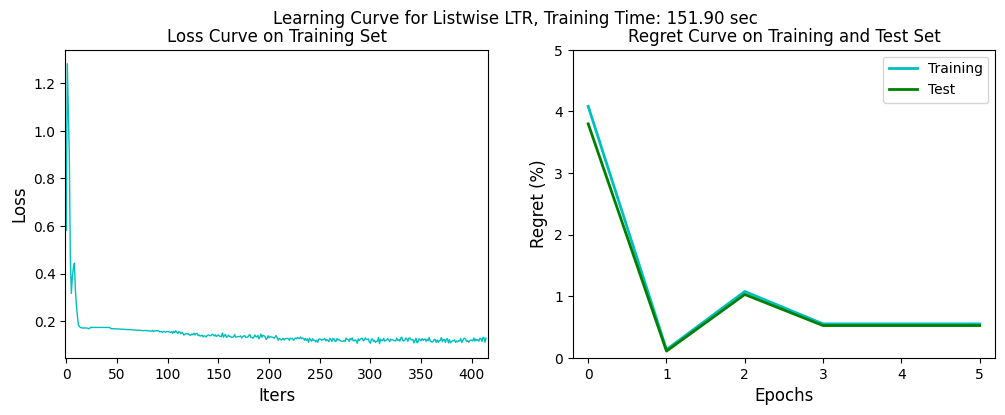

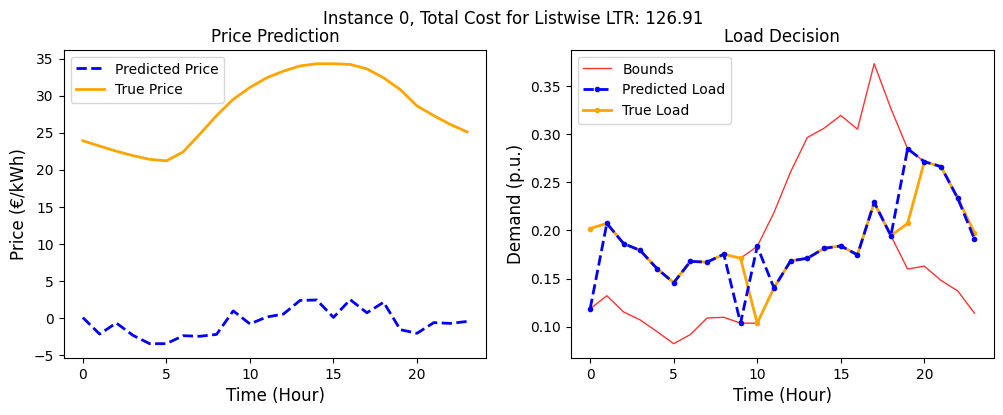





Method: Pairwise LTR


Epoch:  4, Loss: 0.0000: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Pairwise LTR: Regret on test set: 0.31% after 208.47 sec of training


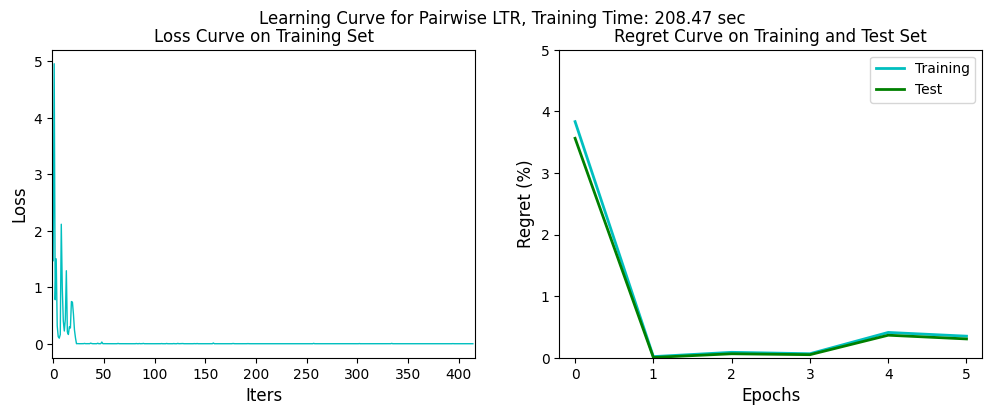

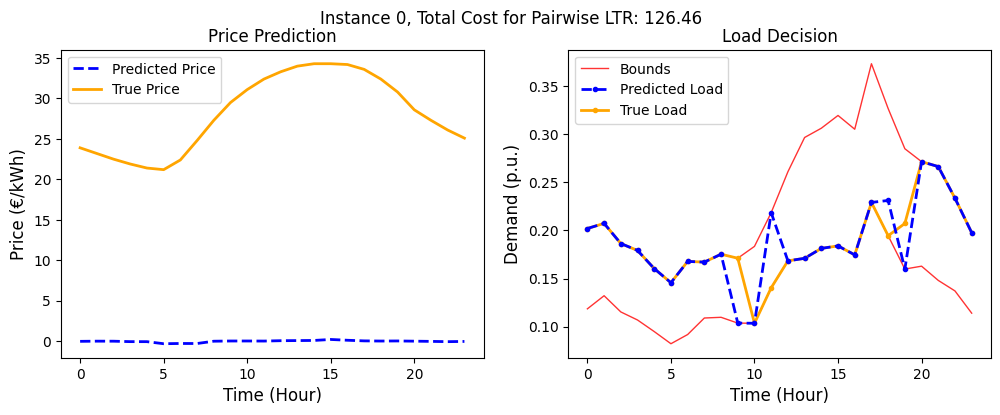





Method: Pointwise LTR


Epoch:  4, Loss: 3606.1011: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Pointwise LTR: Regret on test set: 1.63% after 151.20 sec of training


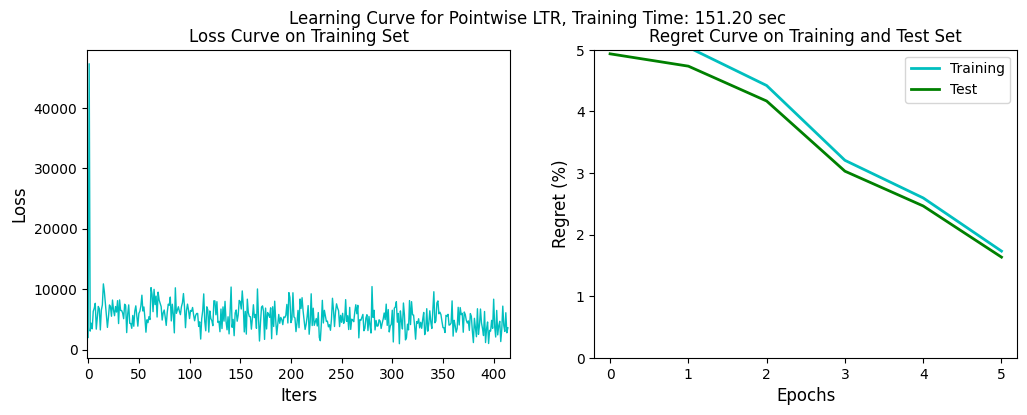

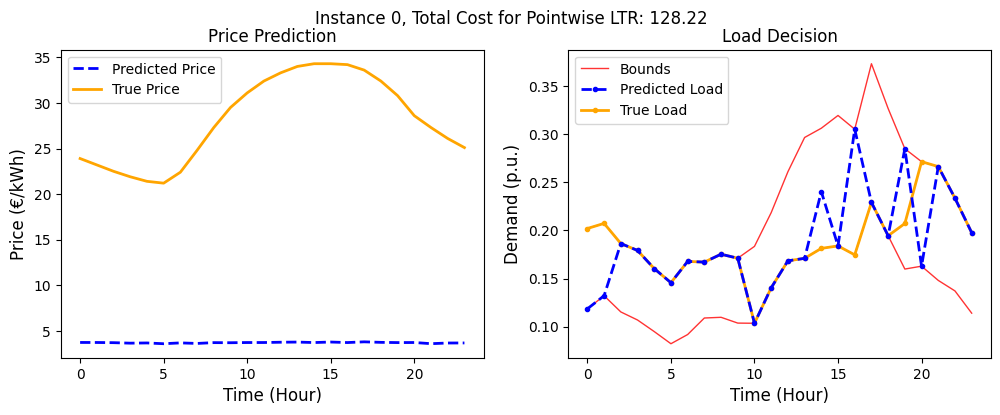

In [ ]:
num_processes = 2 # number of cores
num_epochs = 5    # number of epochs
lr = 1e-2         # learning rate
device = "cpu"    # device to use

# autograd functions
func_dict = {
    "2-Stage": nn.MSELoss(),
    "SPO+" :pyepo.func.SPOPlus(optmodel, processes=num_processes),
    "DBB": pyepo.func.blackboxOpt(optmodel, lambd=20, processes=num_processes),
    "NID": pyepo.func.negativeIdentity(optmodel, processes=num_processes),
    "DPO": pyepo.func.perturbedOpt(optmodel, n_samples=1, sigma=0.5, processes=num_processes),
    "PFYL": pyepo.func.perturbedFenchelYoung(optmodel, n_samples=1, sigma=0.5, processes=num_processes),
    "I-MLE": pyepo.func.implicitMLE(optmodel, n_samples=1, sigma=0.5, lambd=20, processes=num_processes),
    "AI-MLE": pyepo.func.adaptiveImplicitMLE(optmodel, n_samples=1, sigma=0.5, processes=num_processes),
    "NCE": pyepo.func.NCE(optmodel, processes=num_processes, solve_ratio=0.05, dataset=dataset_train),
    "Listwise LTR": pyepo.func.listwiseLTR(optmodel, processes=num_processes, solve_ratio=0.05, dataset=dataset_train),
    "Pairwise LTR": pyepo.func.pairwiseLTR(optmodel, processes=num_processes, solve_ratio=0.05, dataset=dataset_train),
    "Pointwise LTR": pyepo.func.pointwiseLTR(optmodel, processes=num_processes, solve_ratio=0.05, dataset=dataset_train)
}

for method, func in func_dict.items():
    print("Method:", method)
    # init model
    # reg = LinearRegressionNN()
    reg = multiLayerPerceptron(input_dim, hidden_dim, output_dim)
    # training
    logs = trainModel(reg, func, method, loader_train, loader_test, optmodel,
                      device=device, lr=lr, num_epochs=num_epochs)
    # eval
    regret_test = pyepo.metric.regret(reg, optmodel, loader_test)

    # draw plot
    plotLearningCurve(logs, method)
    visSol(plo_t, pup_t, loader_test, optmodel, ind=0, pytorch_model=reg, method_name=method)
    print("\n\n\n")